In [1]:
from utils import *
import os
from grid2op.utils import ScoreL2RPN2020
from CustomGymEnv import CustomGymEnv
import numpy as np
import re

### Parameters of the agents to evaluate

In [2]:
save_path = "./saved_model/lr/"
ENV_NAME = "l2rpn_wcci_2022_dev"
SCOREUSED = ScoreL2RPN2020
gymenv_class = CustomGymEnv
verbose = False
p = Parameters()
p.LIMIT_INFEASIBLE_CURTAILMENT_STORAGE_ACTION = True # It causes errors during training

def filter_chronics(x):
  list_chronics = ["2050-01-03_31",
                   "2050-02-21_31",
                   "2050-03-07_31",
                   "2050-04-18_31"] # Names of chronics to keep
  p = re.compile(".*(" + '|'.join([c + '$' for c in list_chronics]) + ")")
  return re.match(p, x) is not None
  
train_args = {}
train_args["gymenv_kwargs"] = {"safe_max_rho": 0.1}

values_to_test = np.array([1e-5, 3e-5, 1e-4])
var_to_test = "learning_rate"

agents_names = [d for d in os.listdir(save_path) if os.path.isdir(save_path + d)]
agents_names

['CustomGymEnv_2022-05-12_00-18_1',
 'CustomGymEnv_2022-05-12_00-18_3',
 'CustomGymEnv_2022-05-12_00-18_0',
 'CustomGymEnv_2022-05-12_00-18_4',
 'CustomGymEnv_2022-05-12_00-18_2',
 'CustomGymEnv_2022-05-12_00-18_5']

### Evaluation

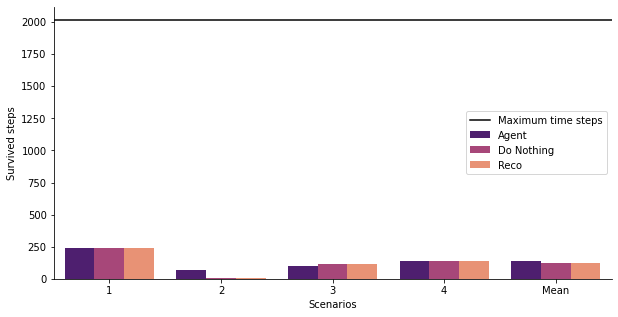

136.75


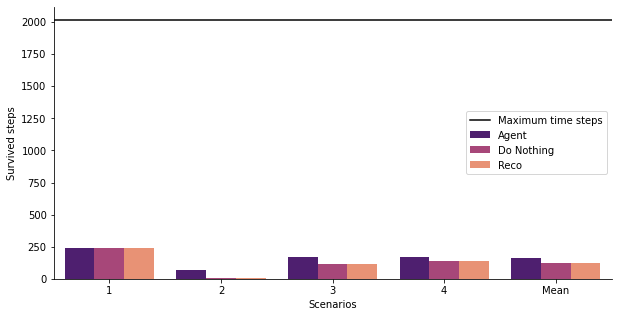

161.75


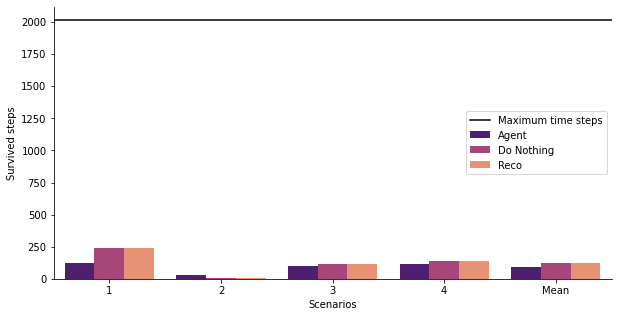

91.5


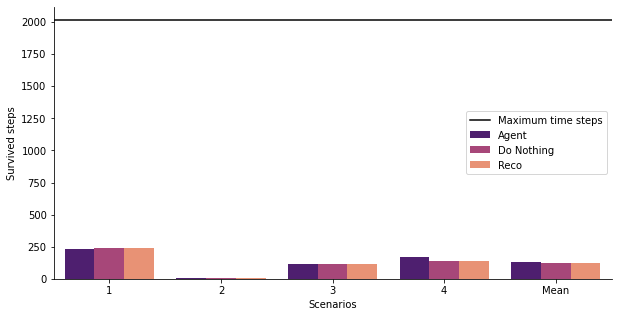

131.0


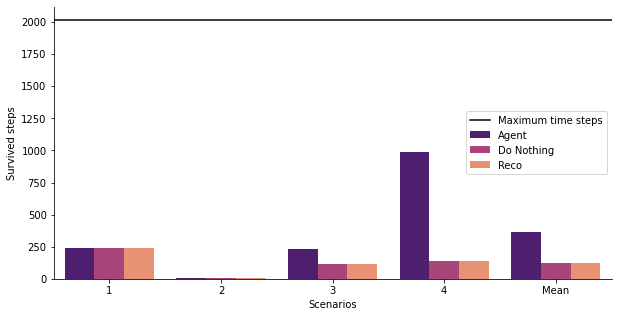

366.25


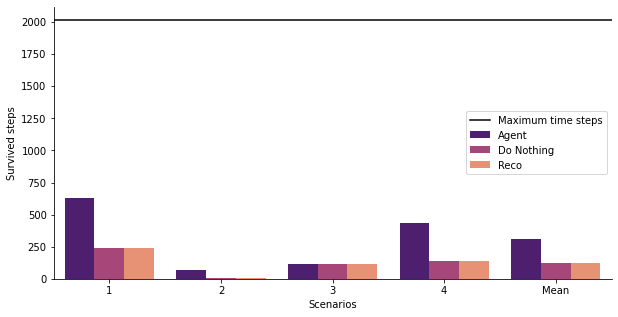

313.75


In [3]:
for i, agent_name in enumerate(agents_names):
  results = eval_agent(ENV_NAME,
            4,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs=train_args["gymenv_kwargs"] if var_to_test!="gymenv_kwargs" else values_to_test[i],
            param=p,
            filter_fun=filter_chronics)
  create_bar_plot(*results)
  print(results[0].mean())

In [4]:
dict_ts_survived = {"Agent": [[], [], [], []]}
dn = []
reco = []

means = np.zeros(len(agents_names))
for i, agent_name in enumerate(agents_names):
  results = eval_agent(ENV_NAME,
            4,
            agent_name,
            save_path,
            SCOREUSED,
            gymenv_class,
            verbose,
            gymenv_kwargs=train_args["gymenv_kwargs"] if var_to_test!="gymenv_kwargs" else values_to_test[i],
            param=p,
            filter_fun=filter_chronics)

  for i, v in enumerate(results[0]):
    dict_ts_survived["Agent"][i].append(v)

  dn = results[1]
  reco = results[2]

"""   create_bar_plot(*results)
  print(results[0].mean())
  means[i] = results[0].mean() """

'   create_bar_plot(*results)\n  print(results[0].mean())\n  means[i] = results[0].mean() '

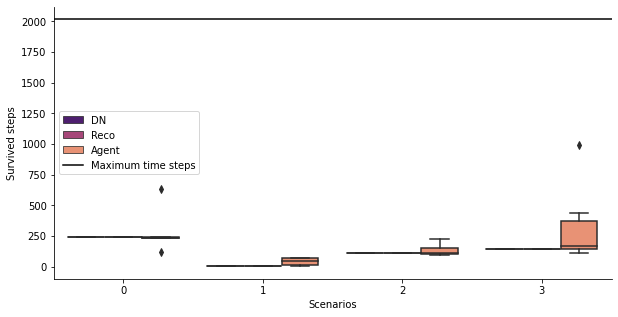

In [5]:
create_box_plot(dict_ts_survived, dn, reco)